
--- XGBoost Regression Results (Yeo–Johnson Target) ---
MAE  = 116,750.07
RMSE = 235,582.99
R²   = 0.685


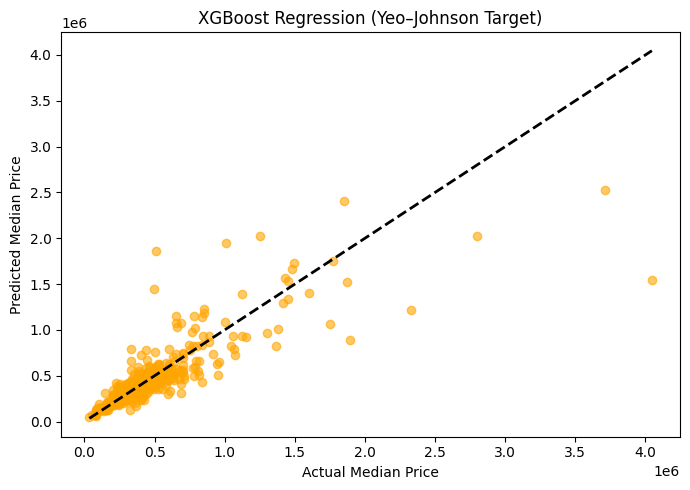

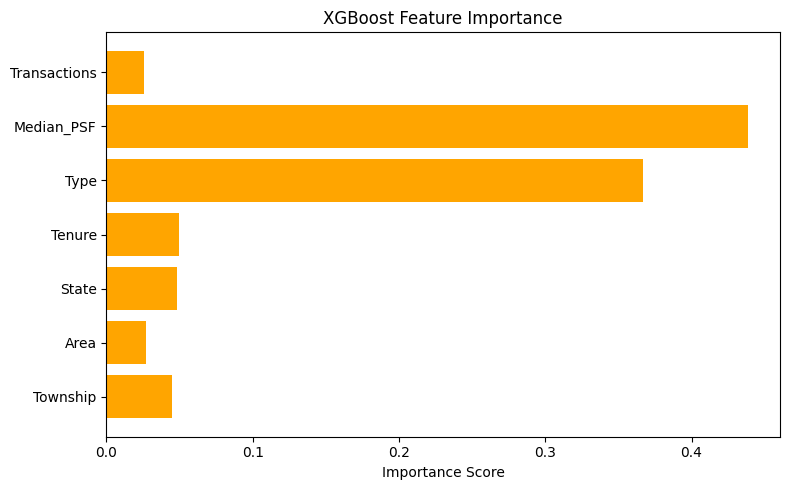

In [ ]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# --- Step 1: Load Dataset (Already Label-Encoded) ---
df = pd.read_csv("malaysia_house_price_data_2025_label_encoded.csv")

# --- Step 2: Separate Features and Target ---
X = df.drop(columns="Median_Price")
y = df["Median_Price"].values.reshape(-1, 1)

# --- Step 3: Split Dataset ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fix skewness first
pt_X = PowerTransformer(method='yeo-johnson')
X_train_pt = pt_X.fit_transform(X_train)
X_test_pt = pt_X.transform(X_test)

pt_y = PowerTransformer(method='yeo-johnson')
y_train_trans = pt_y.fit_transform(y_train)
y_test_trans = pt_y.transform(y_test)


# Then standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_pt)
X_test_scaled = scaler.transform(X_test_pt)

# --- Step 6: Initialize and Train XGBoost Model ---
xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.3,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    reg_alpha=0.1,   # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    n_jobs=-1
)

xgb.fit(X_train_scaled, y_train_trans.ravel())

# --- Step 7: Make Predictions ---
y_pred_trans = xgb.predict(X_test_scaled)

# --- Step 8: Inverse Transform Predictions and Actuals ---
y_pred = pt_y.inverse_transform(y_pred_trans.reshape(-1, 1)).flatten()
y_actual = pt_y.inverse_transform(y_test_trans.reshape(-1, 1)).flatten()

# --- Step 9: Evaluate Model Performance ---
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
r2 = r2_score(y_actual, y_pred)

print("\n--- XGBoost Regression Results (Yeo–Johnson Target) ---")
print(f"MAE  = {mae:,.2f}")
print(f"RMSE = {rmse:,.2f}")
print(f"R²   = {r2:.3f}")

# --- Step 10: Visualization: Actual vs Predicted ---
plt.figure(figsize=(7, 5))
plt.scatter(y_actual, y_pred, color='orange', alpha=0.6)
plt.plot([y_actual.min(), y_actual.max()],
         [y_actual.min(), y_actual.max()],
         'k--', lw=2)
plt.xlabel("Actual Median Price")
plt.ylabel("Predicted Median Price")
plt.title("XGBoost Regression (Yeo–Johnson Target)")
plt.tight_layout()
plt.show()

# --- Step 11: Feature Importance ---
plt.figure(figsize=(8, 5))
importances = xgb.feature_importances_
plt.barh(X.columns, importances, color='orange')
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


Training Deep Learning Model...

--- Deep Learning Model Results ---
MAE  = 270,136.55
RMSE = 392,648.16
R²   = 0.124

COMPARISON: XGBoost vs Deep Learning
        Model           MAE          RMSE       R²
      XGBoost 116750.071045 235582.991791 0.684518
Deep Learning 270136.546690 392648.159784 0.123617

DL vs XGBoost:
MAE  Difference: +153,386.48
RMSE Difference: +157,065.17
R²   Difference: -0.561


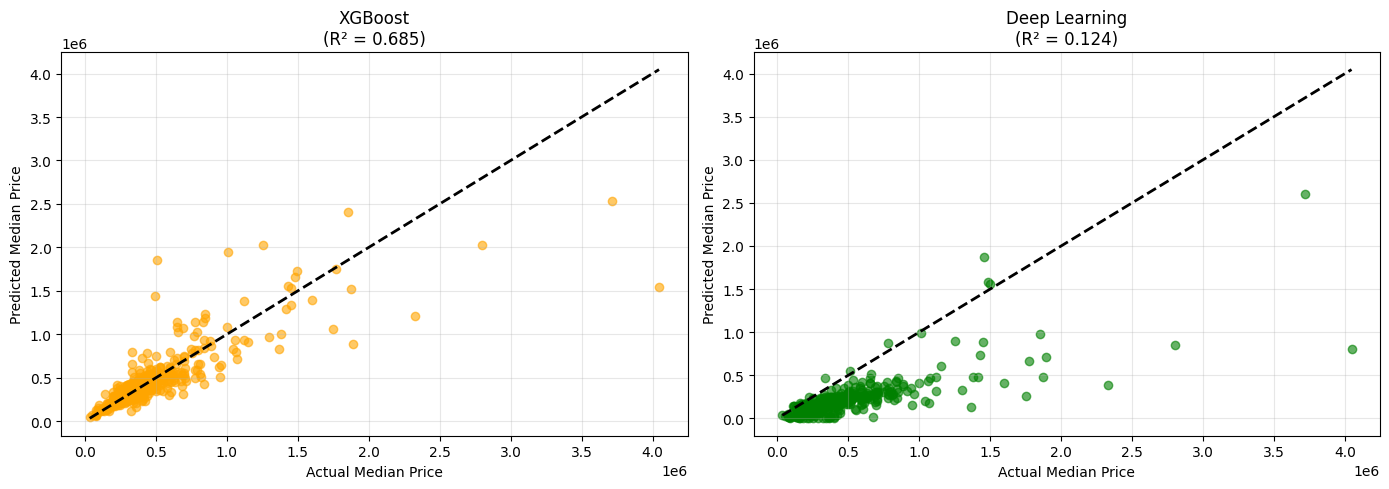

In [11]:
# ============================================
# DEEP LEARNING MODEL
# ============================================
print("Training Deep Learning Model...")

# Load dataset (same split as Cell 0 for fair comparison)
df_dl = pd.read_csv("malaysia_house_price_data_2025_label_encoded.csv")
X_dl = df_dl.drop(columns="Median_Price")
y_dl = df_dl["Median_Price"]

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_dl, y_dl, test_size=0.2, random_state=42
)

# Scale features
scaler_dl = StandardScaler()
X_train_dl_scaled = scaler_dl.fit_transform(X_train_dl)
X_test_dl_scaled = scaler_dl.transform(X_test_dl)

# No target scaling - train directly on raw values
# This avoids numerical instability from inverse transforms

# Simplified architecture focused on stability
model_dl = keras.Sequential([
    layers.Input(shape=(X_train_dl_scaled.shape[1],)),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    
    layers.Dense(1)
])

# Use a smaller learning rate for stability
model_dl.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='mse',
    metrics=['mae']
)

# Training callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=30, 
    min_delta=1000,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7
)

# Train model on raw target values
history = model_dl.fit(
    X_train_dl_scaled, y_train_dl,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    verbose=0,
    callbacks=[early_stop, reduce_lr]
)

# Make predictions (already in original scale)
y_pred_dl = model_dl.predict(X_test_dl_scaled, verbose=0).flatten()
y_actual_dl = y_test_dl.values

# Evaluate
mae_dl = mean_absolute_error(y_actual_dl, y_pred_dl)
rmse_dl = np.sqrt(mean_squared_error(y_actual_dl, y_pred_dl))
r2_dl = r2_score(y_actual_dl, y_pred_dl)

print("\n--- Deep Learning Model Results ---")
print(f"MAE  = {mae_dl:,.2f}")
print(f"RMSE = {rmse_dl:,.2f}")
print(f"R²   = {r2_dl:.3f}")

# ============================================
# COMPARISON TABLE: XGBoost vs Deep Learning
# ============================================
print("\n" + "="*70)
print("COMPARISON: XGBoost vs Deep Learning")
print("="*70)

comparison_df = pd.DataFrame({
    'Model': ['XGBoost', 'Deep Learning'],
    'MAE': [mae, mae_dl],
    'RMSE': [rmse, rmse_dl],
    'R²': [r2, r2_dl]
})

print(comparison_df.to_string(index=False))

# Calculate improvements over XGBoost
mae_diff = mae_dl - mae
rmse_diff = rmse_dl - rmse
r2_diff = r2_dl - r2

print(f"\nDL vs XGBoost:")
print(f"MAE  Difference: {mae_diff:+,.2f}")
print(f"RMSE Difference: {rmse_diff:+,.2f}")
print(f"R²   Difference: {r2_diff:+.3f}")

# ============================================
# COMPARISON VISUALIZATIONS
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: XGBoost (from Cell 0)
axes[0].scatter(y_actual, y_pred, color='orange', alpha=0.6)
axes[0].plot([y_actual.min(), y_actual.max()],
             [y_actual.min(), y_actual.max()],
             'k--', lw=2)
axes[0].set_xlabel("Actual Median Price")
axes[0].set_ylabel("Predicted Median Price")
axes[0].set_title(f"XGBoost\n(R² = {r2:.3f})")
axes[0].grid(True, alpha=0.3)

# Plot 2: Deep Learning
axes[1].scatter(y_actual_dl, y_pred_dl, color='green', alpha=0.6)
axes[1].plot([y_actual_dl.min(), y_actual_dl.max()],
             [y_actual_dl.min(), y_actual_dl.max()],
             'k--', lw=2)
axes[1].set_xlabel("Actual Median Price")
axes[1].set_ylabel("Predicted Median Price")
axes[1].set_title(f"Deep Learning\n(R² = {r2_dl:.3f})")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Additional Comparison: Bar Chart
# ============================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Bar chart data
models = ['XGBoost', 'Deep Learning']
mae_values = [mae, mae_dl]
rmse_values = [rmse, rmse_dl]
r2_values = [r2, r2_dl]

# MAE Comparison
axes[0].bar(models, mae_values, color=['#FFA500', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[0].set_ylabel('MAE (RM)')
axes[0].set_title('Mean Absolute Error')
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(mae_values):
    axes[0].text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontweight='bold')

# RMSE Comparison
axes[1].bar(models, rmse_values, color=['#FFA500', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('RMSE (RM)')
axes[1].set_title('Root Mean Squared Error')
axes[1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(rmse_values):
    axes[1].text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontweight='bold')

# R² Comparison
axes[2].bar(models, r2_values, color=['#FFA500', '#2ecc71'], alpha=0.7, edgecolor='black')
axes[2].set_ylabel('R² Score')
axes[2].set_title('R² Score')
axes[2].grid(True, alpha=0.3, axis='y')
axes[2].set_ylim([min(r2_values) * 1.1 if min(r2_values) < 0 else min(r2_values) - 0.1, 
                  max(r2_values) * 1.05 if max(r2_values) > 0 else max(r2_values) + 0.1])
for i, v in enumerate(r2_values):
    axes[2].text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Model Comparison: XGBoost vs Deep Learning', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()
